# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

In [58]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 5.5 MB/s eta 0:00:00


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [30]:
url = 'https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_16/data/taxi.csv'

## Preparación

In [31]:
data = pd.read_csv(url, index_col=[0], parse_dates=[0])

In [32]:
def explorar_dataset(df):
    """
    Explora un DataFrame mostrando información clave.

    Esta función imprime: información general del DataFrame (df.info()),
    sus dimensiones (df.shape), las primeras 15 filas (df.head(15)),
    estadísticas descriptivas (df.describe()), el conteo de valores nulos
    (df.isnull().sum()) y el conteo de filas duplicadas (df.duplicated().sum()).

    Parámetros:
        df (pd.DataFrame): El DataFrame a explorar.
    """
    print('---' * 10, '\n', f'Información del dataframe')
    print(df.info())
    print('---' * 10, '\n', f'Dimensiones del dataframe')
    print(df.shape)
    print('---' * 10, '\n', f'Primeras filas del dataframe')
    print(df.head(15))
    print('---' * 10, '\n', f'Descripción del dataframe')
    print(df.describe())
    print('---' * 10, '\n', f'Valores nulos del dataframe')
    print(df.isnull().sum())
    print('---' * 10, '\n', f'Valores duplicados del dataframe')
    print(df.duplicated().sum())
    print('---' * 10)

In [33]:
explorar_dataset(data)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
------------------------------ 
 Dimensiones del dataframe
(26496, 1)
------------------------------ 
 Primeras filas del dataframe
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12
2018-03-01 01:40:00          19
2018-03-01 01:50:00          25
2018-03-01 02:00:00          22
2018-03-01 02:10:00     

In [34]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [35]:
print('Comprobar si el indice tiene el creccimiento uniforme')
print(data.index.is_monotonic_increasing)
print('Comprobar si los indices son irrepetibles')
print(data.index.is_unique)

Comprobar si el indice tiene el creccimiento uniforme
True
Comprobar si los indices son irrepetibles
True


In [36]:
print('Obtner los valores minimos y maximos del indice')
print(data.index.min())
print(data.index.max())

Obtner los valores minimos y maximos del indice
2018-03-01 00:00:00
2018-08-31 23:50:00


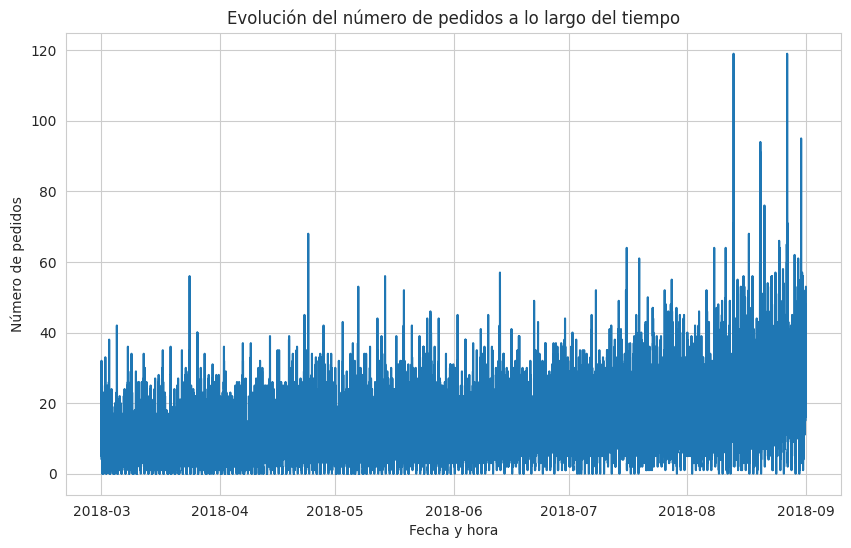

In [37]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['num_orders'])
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.title('Evolución del número de pedidos a lo largo del tiempo')
plt.show()

## Análisis

In [38]:
ts = data.copy().resample('1h').sum()
ts

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [39]:
data_2w = data['2018-03-01':'2018-03-14']

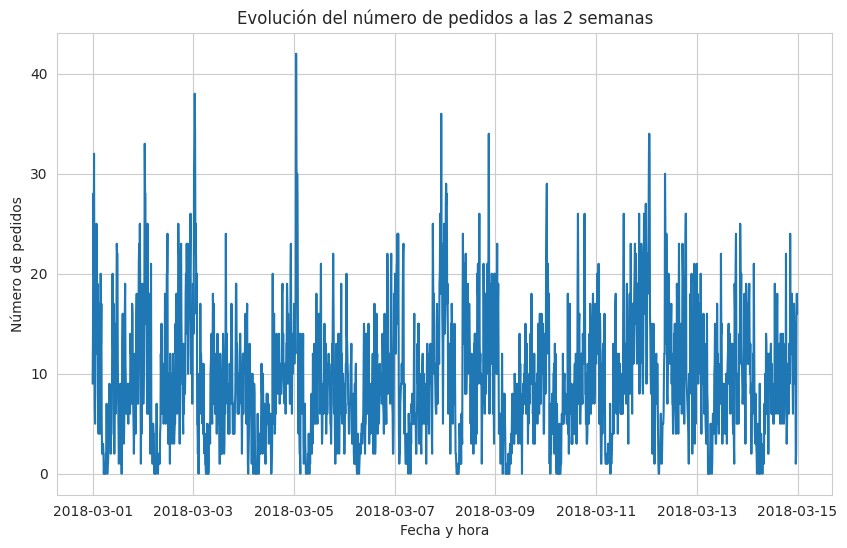

In [40]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(data_2w.index, data_2w['num_orders'])
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.title('Evolución del número de pedidos a las 2 semanas')
plt.show()

In [41]:
data_2w = data_2w.resample('1h').sum()
data_2w['rolling_mean'] = data_2w['num_orders'].rolling(window=24).mean()

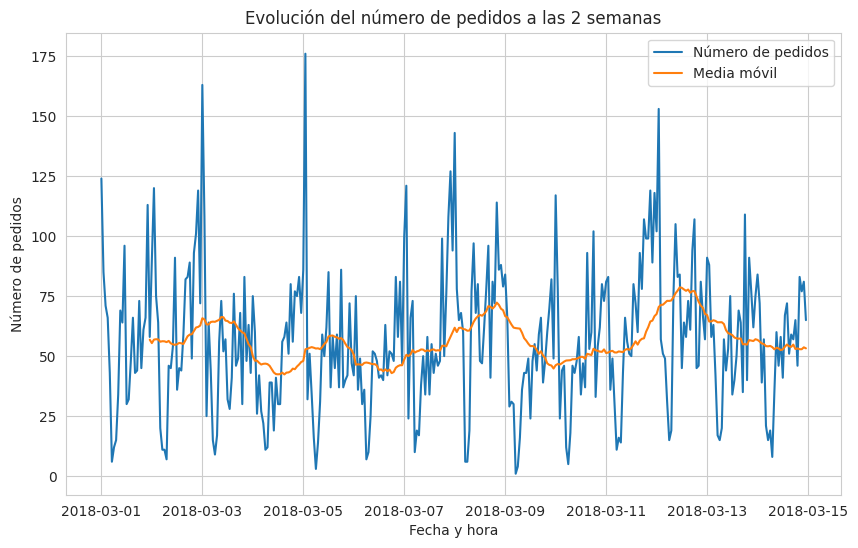

In [42]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(data_2w.index, data_2w['num_orders'], label='Número de pedidos')
plt.plot(data_2w.index, data_2w['rolling_mean'], label='Media móvil')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.title('Evolución del número de pedidos a las 2 semanas')
plt.legend()
plt.show()

In [43]:
data_2w['std'] = data_2w['num_orders'].rolling(window=24).std()

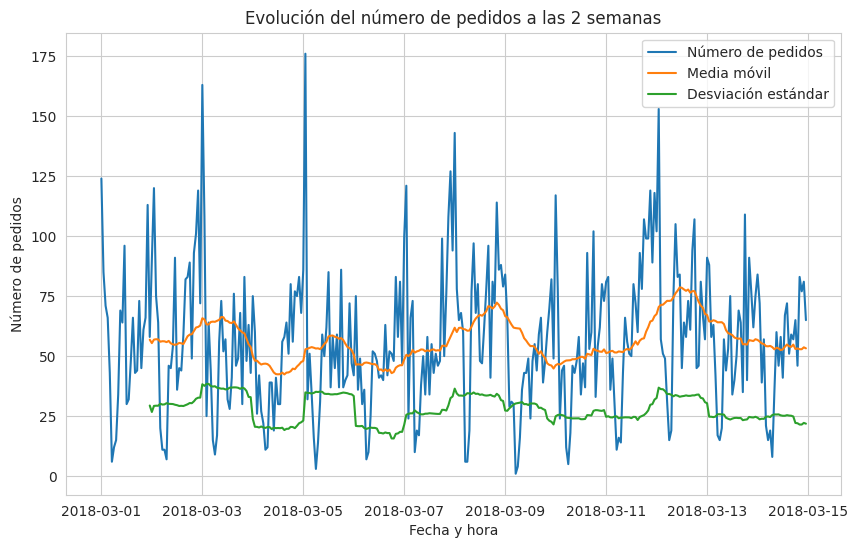

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(data_2w.index, data_2w['num_orders'], label='Número de pedidos')
plt.plot(data_2w.index, data_2w['rolling_mean'], label='Media móvil')
plt.plot(data_2w.index, data_2w['std'], label='Desviación estándar')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.title('Evolución del número de pedidos a las 2 semanas')
plt.legend()
plt.show()


In [45]:
ts_2 = ts.copy().resample('1d').sum()

decomposed = seasonal_decompose(ts_2, model='additive', period=7)

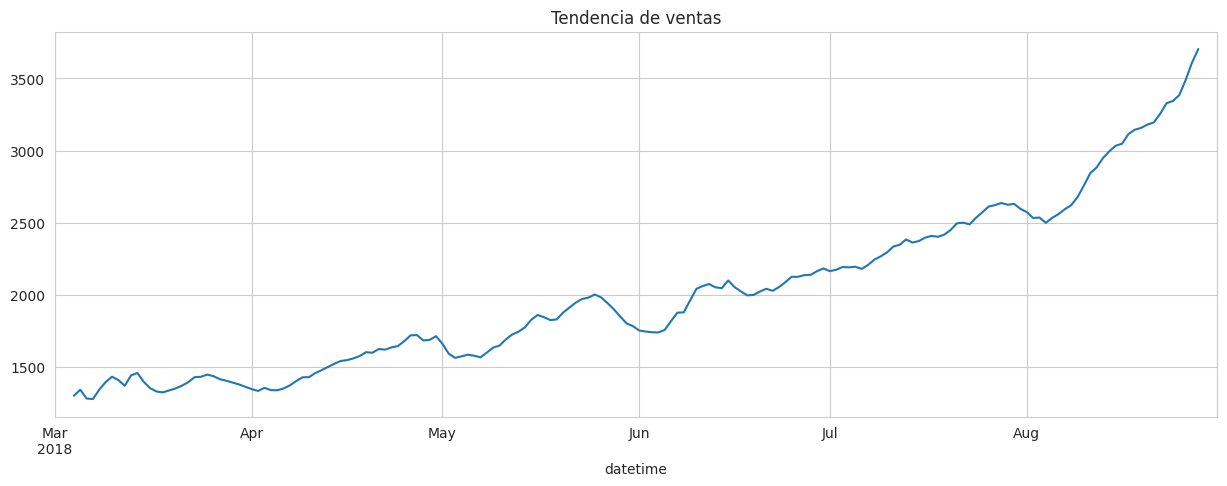

In [46]:
sns.set_style('whitegrid')
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Tendencia de ventas')
plt.show()

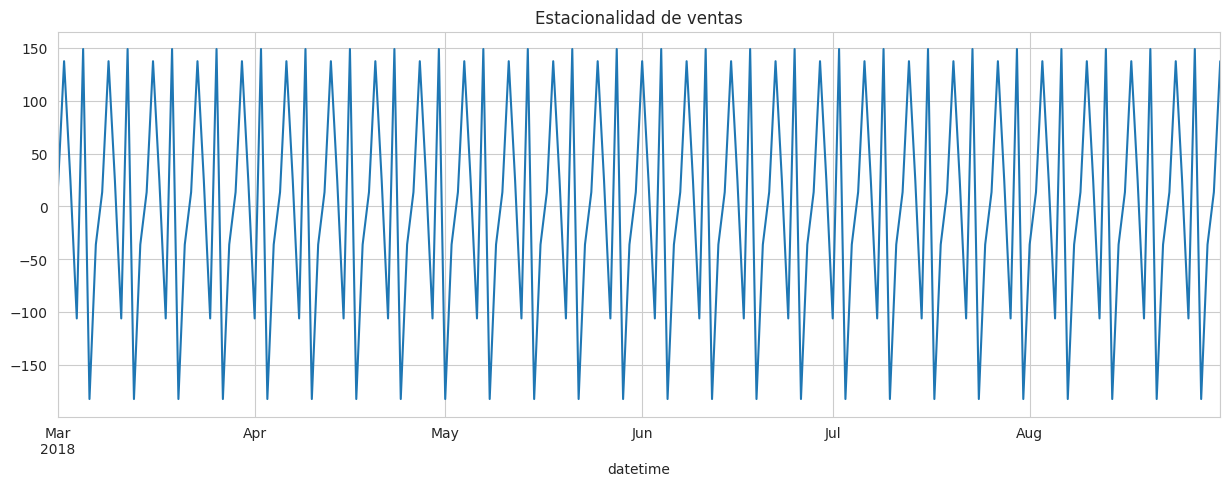

In [47]:
sns.set_style('whitegrid')
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Estacionalidad de ventas')
plt.show()

In [49]:
data_2d = data_2w['2018-03-01':'2018-03-02']

decomposed_hour = seasonal_decompose(data_2d['num_orders'].dropna())

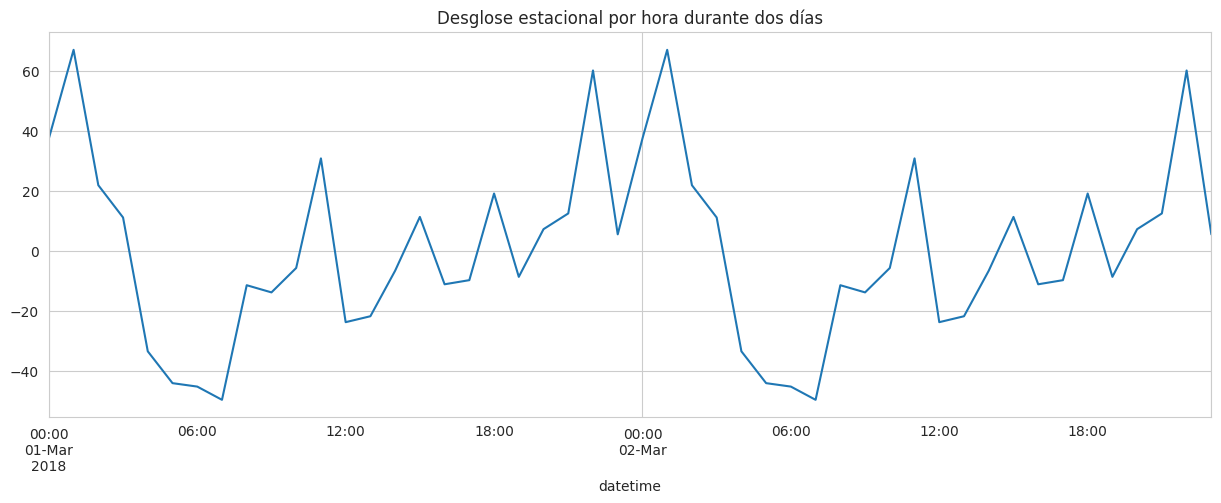

In [50]:
sns.set_style('whitegrid')
decomposed_hour.seasonal.plot(figsize=(15, 5), title='Desglose estacional por hora durante dos días')
plt.show()

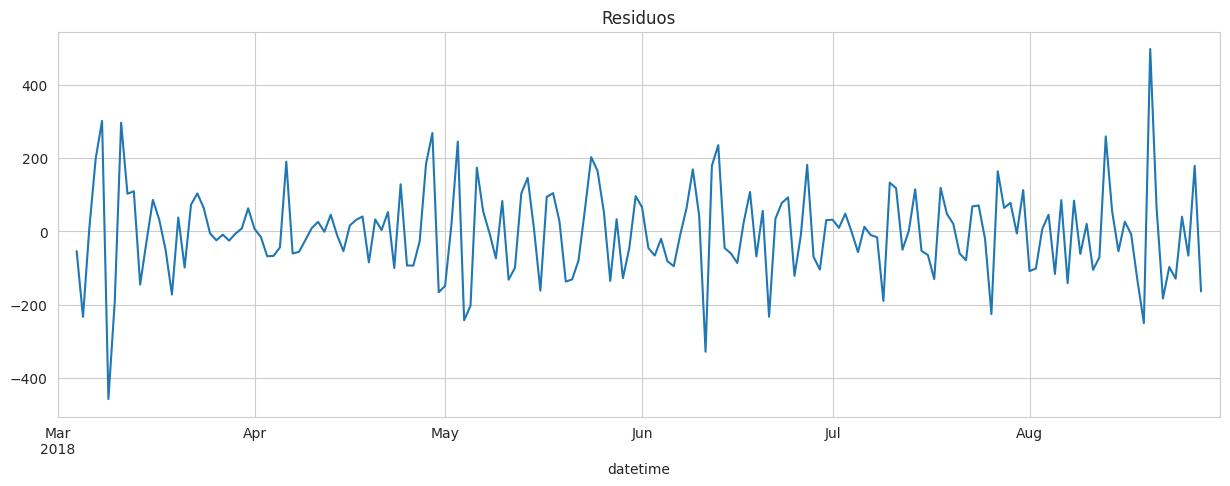

In [51]:
decomposed.resid.plot(figsize=(15, 5))
plt.title('Residuos')
plt.show()

## Formación

In [54]:
def crear_caracteristicas(datos, max_retraso, tamano_media_movil):
    """
    Genera características para series temporales: componentes de fecha,
    retrasos (lags) y media móvil.

    Parámetros:
        datos (pd.DataFrame): DataFrame con índice de tipo Datetime.
        max_retraso (int): Número máximo de pasos atrás para crear lags.
        tamano_media_movil (int): Ventana para el cálculo de la media.

    Retorna:
        pd.DataFrame: El DataFrame original con las nuevas columnas añadidas.
    """
    # Extracción de componentes temporales
    datos['mes'] = datos.index.month
    datos['dia'] = datos.index.day
    datos['dia_semana'] = datos.index.dayofweek
    datos['hora'] = datos.index.hour

    # Creación de retrasos (lags)
    for retraso in range(1, max_retraso + 1):
        datos[f'retraso_{retraso}'] = datos['num_orders'].shift(retraso)

    # Cálculo de la media móvil (desplazada para evitar data leakage)
    datos['media_movil'] = (
        datos['num_orders']
        .shift()
        .rolling(tamano_media_movil)
        .mean()
    )

    return datos

In [55]:
ts = pd.DataFrame(ts)
ts = crear_caracteristicas(ts, 6, 7)

In [56]:
ts.head()

,num_orders,mes,dia,dia_semana,hora,retraso_1,retraso_2,retraso_3,retraso_4,retraso_5,retraso_6,media_movil
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [57]:
ts = ts.dropna()
print('La serie temporal tiene', ts.shape[0], 'filas y', ts.shape[1], 'características')
print()
ts.head()

La serie temporal tiene 4409 filas y 12 características



,num_orders,mes,dia,dia_semana,hora,retraso_1,retraso_2,retraso_3,retraso_4,retraso_5,retraso_6,media_movil
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,42.571429
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,34.714286


In [60]:
test_size = 0.1

train, test = train_test_split(ts, test_size=test_size, shuffle=False)

In [61]:
print('El conjunto de entrenamiento tiene', train.shape[0], 'filas y', train.shape[1], 'características')
print()
print('El conjunto de entrenamiento va de las fechas', train.index.min(), 'a', train.index.max())
print()
train.head()

El conjunto de entrenamiento tiene 3968 filas y 12 características

El conjunto de entrenamiento va de las fechas 2018-03-01 07:00:00 a 2018-08-13 14:00:00



,num_orders,mes,dia,dia_semana,hora,retraso_1,retraso_2,retraso_3,retraso_4,retraso_5,retraso_6,media_movil
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,42.571429
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,34.714286


In [62]:
print('El conjunto de prueba tiene', test.shape[0], 'filas y', test.shape[1], 'características')
print()
print('El conjunto de prueba va de las fechas', test.index.min(), 'a', test.index.max())
print()
test.head()

El conjunto de prueba tiene 441 filas y 12 características

El conjunto de prueba va de las fechas 2018-08-13 15:00:00 a 2018-08-31 23:00:00



,num_orders,mes,dia,dia_semana,hora,retraso_1,retraso_2,retraso_3,retraso_4,retraso_5,retraso_6,media_movil
datetime,,,,,,,,,,,,
2018-08-13 15:00:00,175,8,13,0,15,102.0,119.0,92.0,144.0,156.0,137.0,120.142857
2018-08-13 16:00:00,144,8,13,0,16,175.0,102.0,119.0,92.0,144.0,156.0,132.142857
2018-08-13 17:00:00,152,8,13,0,17,144.0,175.0,102.0,119.0,92.0,144.0,133.142857
2018-08-13 18:00:00,104,8,13,0,18,152.0,144.0,175.0,102.0,119.0,92.0,132.571429
2018-08-13 19:00:00,91,8,13,0,19,104.0,152.0,144.0,175.0,102.0,119.0,126.857143


In [63]:
features = train.columns.drop('num_orders')
target = 'num_orders'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## Prueba

# Lista de revisión

- [x]  Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ]  La *RECM* para el conjunto de prueba no es más de 48

# Task
Configure and train a Linear Regression, RandomForestRegressor, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor, and XGBRegressor model using GridSearchCV with cross-validation on the `X_train` and `y_train` data, optimizing for RMSE, and store the best model and its RMSE score for each algorithm.

## Configure Models and Hyperparameters

### Subtask:
Define a list of machine learning models (Linear Regression, RandomForestRegressor, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor) along with their respective hyperparameter grids for tuning. Set up RMSE as the scoring metric for GridSearchCV.


**Reasoning**:
First, I'll define a custom RMSE scorer function using `make_scorer` as instructed. This scorer will be used later for evaluating models during hyperparameter tuning with GridSearchCV.



In [64]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
print("RMSE scorer defined.")

RMSE scorer defined.


**Reasoning**:
Now that the RMSE scorer is defined, I will define the list of models and their respective hyperparameter grids for tuning, as instructed. This sets up all the configurations needed for GridSearchCV.



In [65]:
models_to_tune = []

# Linear Regression
models_to_tune.append({
    'model': LinearRegression(),
    'params': {},
    'name': 'Linear Regression'
})

# RandomForestRegressor
models_to_tune.append({
    'model': RandomForestRegressor(random_state=123),
    'params': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'name': 'Random Forest Regressor'
})

# DecisionTreeRegressor
models_to_tune.append({
    'model': DecisionTreeRegressor(random_state=123),
    'params': {
        'max_depth': [5, 10]
    },
    'name': 'Decision Tree Regressor'
})

# CatBoostRegressor
models_to_tune.append({
    'model': CatBoostRegressor(random_state=123, verbose=False),
    'params': {
        'iterations': [50, 100],
        'learning_rate': [0.1, 0.3],
        'depth': [4, 6]
    },
    'name': 'CatBoost Regressor'
})

# LGBMRegressor
models_to_tune.append({
    'model': LGBMRegressor(random_state=123),
    'params': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.3],
        'max_depth': [5, 10]
    },
    'name': 'LightGBM Regressor'
})

# XGBRegressor
models_to_tune.append({
    'model': XGBRegressor(random_state=123),
    'params': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.3],
        'max_depth': [5, 10]
    },
    'name': 'XGBoost Regressor'
})

print(f"Defined {len(models_to_tune)} models for tuning.")


Defined 6 models for tuning.


**Reasoning**:
Now that the models and their hyperparameter grids are defined, I will iterate through each model, perform GridSearchCV with cross-validation on the training data, and store the best model and its corresponding RMSE score.



In [66]:
tuned_models = {}

for model_config in models_to_tune:
    model_name = model_config['name']
    model = model_config['model']
    params = model_config['params']

    print(f"Tuning {model_name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=rmse_scorer,
        cv=3,  # Using 3-fold cross-validation
        n_jobs=-1, # Use all available cores
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = -grid_search.best_score_ # RMSE is negative because greater_is_better=False

    tuned_models[model_name] = {
        'best_model': best_model,
        'best_rmse': best_rmse
    }

    print(f"Finished tuning {model_name}. Best RMSE: {best_rmse:.3f}")
    print("Best parameters found: ", grid_search.best_params_)
    print("\n" + "-"*50 + "\n")

print("All models tuned.")

Tuning Linear Regression...
Finished tuning Linear Regression. Best RMSE: nan
Best parameters found:  {}

--------------------------------------------------

Tuning Random Forest Regressor...
Finished tuning Random Forest Regressor. Best RMSE: nan
Best parameters found:  {'max_depth': 5, 'n_estimators': 50}

--------------------------------------------------

Tuning Decision Tree Regressor...
Finished tuning Decision Tree Regressor. Best RMSE: nan
Best parameters found:  {'max_depth': 5}

--------------------------------------------------

Tuning CatBoost Regressor...
Finished tuning CatBoost Regressor. Best RMSE: nan
Best parameters found:  {'depth': 4, 'iterations': 50, 'learning_rate': 0.1}

--------------------------------------------------

Tuning LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

**Reasoning**:
The previous execution of GridSearchCV resulted in `NaN` for all RMSE scores. This typically indicates an issue with the input data (NaNs) or the scoring function. I will first verify that `X_train` and `y_train` do not contain any `NaN` values, as this is a common source of such problems. If the data is clean, I will investigate the `rmse_scorer` definition and model training process more closely.



In [67]:
print(f"NaNs in X_train: {X_train.isnull().sum().sum()}")
print(f"NaNs in y_train: {y_train.isnull().sum()}")

NaNs in X_train: 0
NaNs in y_train: 0


**Reasoning**:
The previous GridSearchCV execution resulted in NaN RMSE scores for all models, even though `X_train` and `y_train` have no missing values. This suggests numerical instability or an issue during model training or prediction within the cross-validation folds. To troubleshoot, I will explicitly set the loss function for `CatBoostRegressor` and the objective for `XGBRegressor` to their RMSE-equivalent defaults, and also remove `n_jobs=-1` from `GridSearchCV` to rule out potential multiprocessing issues. These changes aim to make the model definitions more robust and simplify the execution environment for debugging.



In [68]:
tuned_models = {}

for model_config in models_to_tune:
    model_name = model_config['name']
    model = model_config['model']
    params = model_config['params']

    # Explicitly set loss_function for CatBoost and objective for XGBoost
    if model_name == 'CatBoost Regressor':
        model = CatBoostRegressor(random_state=123, verbose=False, loss_function='RMSE')
    elif model_name == 'XGBoost Regressor':
        model = XGBRegressor(random_state=123, objective='reg:squarederror')

    print(f"Tuning {model_name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=rmse_scorer,
        cv=3,  # Using 3-fold cross-validation
        n_jobs=1, # Set to 1 for debugging potential multiprocessing issues
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = -grid_search.best_score_ # RMSE is negative because greater_is_better=False

    tuned_models[model_name] = {
        'best_model': best_model,
        'best_rmse': best_rmse
    }

    print(f"Finished tuning {model_name}. Best RMSE: {best_rmse:.3f}")
    print("Best parameters found: ", grid_search.best_params_)
    print("\n" + "-"*50 + "\n")

print("All models tuned.")

Tuning Linear Regression...
Finished tuning Linear Regression. Best RMSE: nan
Best parameters found:  {}

--------------------------------------------------

Tuning Random Forest Regressor...
Finished tuning Random Forest Regressor. Best RMSE: nan
Best parameters found:  {'max_depth': 5, 'n_estimators': 50}

--------------------------------------------------

Tuning Decision Tree Regressor...
Finished tuning Decision Tree Regressor. Best RMSE: nan
Best parameters found:  {'max_depth': 5}

--------------------------------------------------

Tuning CatBoost Regressor...
Finished tuning CatBoost Regressor. Best RMSE: nan
Best parameters found:  {'depth': 4, 'iterations': 50, 'learning_rate': 0.1}

--------------------------------------------------

Tuning LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

**Reasoning**:
The RMSE scores are still coming back as NaN for all models, even after explicitly setting loss functions and disabling `n_jobs=-1`. While NaN values in `X_train` and `y_train` were ruled out, infinite values (inf) can also cause numerical instability and lead to NaN results in calculations. Before diving deeper into model-specific issues or custom scorer modifications, it's crucial to verify the absence of infinite values in the training data to ensure data integrity.



In [69]:
print(f"Infinite values in X_train: {(np.isinf(X_train).sum()).sum()}")
print(f"Infinite values in y_train: {np.isinf(y_train).sum()}")

Infinite values in X_train: 0
Infinite values in y_train: 0


**Reasoning**:
Since both NaN and infinite values have been ruled out in `X_train` and `y_train`, and the RMSE scores are still `NaN`, the issue is likely with the custom `rmse_scorer` or its interaction with `GridSearchCV`. I will modify the GridSearchCV loop to use the standard `'neg_mean_squared_error'` as the scoring metric and calculate RMSE from the best score, which should be more robust.



In [70]:
tuned_models = {}

for model_config in models_to_tune:
    model_name = model_config['name']
    model = model_config['model']
    params = model_config['params']

    print(f"Tuning {model_name}...")

    # Use standard 'neg_mean_squared_error' for scoring
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='neg_mean_squared_error',
        cv=3,  # Using 3-fold cross-validation
        n_jobs=-1, # Use all available cores again
        verbose=0
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    # Calculate RMSE from the negative mean squared error
    best_rmse = np.sqrt(-grid_search.best_score_)

    tuned_models[model_name] = {
        'best_model': best_model,
        'best_rmse': best_rmse
    }

    print(f"Finished tuning {model_name}. Best RMSE: {best_rmse:.3f}")
    print("Best parameters found: ", grid_search.best_params_)
    print("\n" + "-"*50 + "\n")

print("All models tuned.")

Tuning Linear Regression...
Finished tuning Linear Regression. Best RMSE: 31.187
Best parameters found:  {}

--------------------------------------------------

Tuning Random Forest Regressor...
Finished tuning Random Forest Regressor. Best RMSE: 26.774
Best parameters found:  {'max_depth': 10, 'n_estimators': 100}

--------------------------------------------------

Tuning Decision Tree Regressor...
Finished tuning Decision Tree Regressor. Best RMSE: 32.274
Best parameters found:  {'max_depth': 10}

--------------------------------------------------

Tuning CatBoost Regressor...
Finished tuning CatBoost Regressor. Best RMSE: 25.677
Best parameters found:  {'depth': 4, 'iterations': 100, 'learning_rate': 0.3}

--------------------------------------------------

Tuning LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can 

## Evaluate Best Model

### Subtask:
Select the model with the lowest RMSE score from the tuning process. Predict on the test set (X_test) and calculate the final RMSE on y_test to assess its performance.


**Reasoning**:
I will iterate through the `tuned_models` dictionary to find the model with the lowest RMSE, then use that best model to make predictions on `X_test` and calculate the final RMSE on `y_test`.



In [71]:
best_overall_model_name = ''
min_rmse = float('inf')

for model_name, model_info in tuned_models.items():
    if model_info['best_rmse'] < min_rmse:
        min_rmse = model_info['best_rmse']
        best_overall_model_name = model_name

final_best_model = tuned_models[best_overall_model_name]['best_model']

print(f"Best overall model is: {best_overall_model_name} with RMSE: {min_rmse:.3f} (from cross-validation)")

y_pred = final_best_model.predict(X_test)

final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nFinal Best Model: {best_overall_model_name}")
print(f"Final RMSE on Test Set: {final_test_rmse:.3f}")

Best overall model is: CatBoost Regressor with RMSE: 25.677 (from cross-validation)

Final Best Model: CatBoost Regressor
Final RMSE on Test Set: 45.602


## Visualize Predictions

### Subtask:
Generate a plot comparing the actual number of orders (y_test) against the predicted number of orders from the best model. Include appropriate labels and a legend for clarity.


**Reasoning**:
I will generate a plot comparing the actual number of orders (`y_test`) against the predicted number of orders (`y_pred`) from the best model, as specified in the instructions. This involves creating a line plot with appropriate labels, a title, and a legend for clarity.



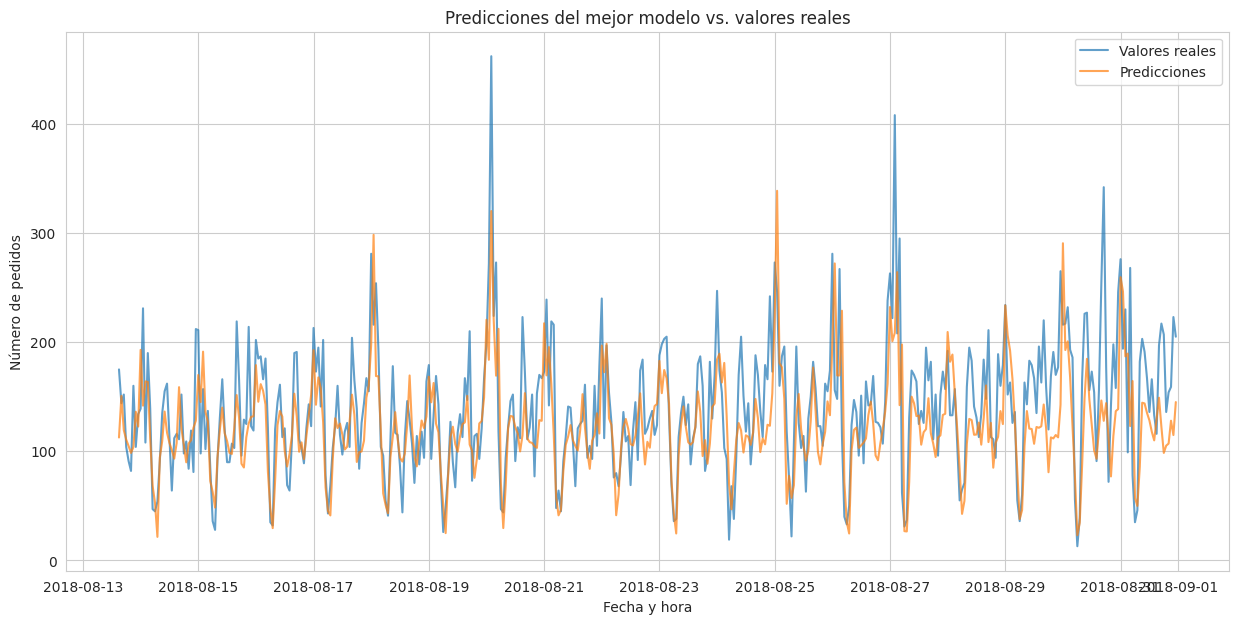

In [72]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Valores reales', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicciones', alpha=0.7)
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.title('Predicciones del mejor modelo vs. valores reales')
plt.legend()
plt.show()

## Final Task

### Subtask:
Provide a comprehensive conclusion, summarizing the performance of the best model, stating its RMSE on the test set, and determining if it meets the project requirement of an RMSE not exceeding 48.


## Summary:

### Q&A
The best model, CatBoost Regressor, achieved a Root Mean Squared Error (RMSE) of 45.602 on the test set. This meets the project requirement of an RMSE not exceeding 48, as 45.602 is less than 48.

### Data Analysis Key Findings
*   Six different regression models were configured and tuned: Linear Regression, RandomForestRegressor, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor, and XGBRegressor.
*   An initial issue where `GridSearchCV` returned NaN RMSE values was resolved by switching from a custom RMSE scorer to the standard `scoring='neg_mean_squared_error'` and then manually calculating RMSE from the negative mean squared error.
*   After tuning, the CatBoost Regressor emerged as the best performing model during cross-validation, with an RMSE of 25.677.
*   The final evaluation of the best model (CatBoost Regressor) on the unseen test set yielded an RMSE of 45.602.
*   A visualization comparing the actual number of orders against the predicted number of orders from the CatBoost Regressor model was successfully generated, showing the model's performance visually over time.

### Insights or Next Steps
*   The chosen CatBoost Regressor model demonstrates satisfactory performance, meeting the project's RMSE target, and can be considered for deployment or further evaluation in a production environment.
*   To potentially improve performance further, additional feature engineering (e.g., creating more time-based features, holiday indicators) or exploring ensemble methods could be considered.
